In [35]:
import ast
import datetime
import gensim
import gensim.corpora as corpora
import logging
import math
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim
import re
import seaborn as sns
import spacy
import string
import warnings

from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import warnings

%matplotlib inline

# Enable logging for gensim - optional
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

warnings.filterwarnings('ignore')

In this file we perform an initial exploratory data analysis, topic modelling and sentiment analysis on a random subsample of the dataset to gain an initial insight of the dataset.

# Exploratory data analysis

In [36]:
data_file = './parler_data000000000133_2020_2021_subsample.csv'
df = pd.read_csv(data_file)
df.columns

Index(['Unnamed: 0', 'comments', 'body', 'bodywithurls', 'createdAt',
       'createdAtformatted', 'creator', 'datatype', 'depth', 'depthRaw',
       'followers', 'following', 'hashtags', 'id', 'lastseents', 'links',
       'media', 'parent', 'posts', 'sensitive', 'shareLink', 'upvotes', 'urls',
       'username', 'verified', 'article', 'impressions', 'preview', 'reposts',
       'state', 'color', 'commentDepth', 'controversy', 'conversation',
       'downvotes', 'post', 'score', 'isPrimary', 'replyingTo'],
      dtype='object')

In [37]:
# Drop 'body' NaN.
df = df.dropna(subset=['body', 'bodywithurls']).copy()

# Extract hashtags from the body of the posts/comments.
df['hashtaghs'] = df.body.str.findall(r'(\#\w+)').copy()

# Convert hashtags to list literal.
df.loc['hashtaghs', :] = df.hashtags.apply(ast.literal_eval).copy()

# Remove posts without a body
df = df[~df.body.isnull()]
welcome_txt = 'Welcome! For people looking for Parler tips and how tos Check out @parlersupport or the Parler Youtube page. The videos are in both places. There is also a Parler101 channel which has some good data as well.'

# Remove welcome comments and posts from Parler moderators.
df = df[df.hashtags.apply(lambda x: 'newuser' not in x and 'parlerconcierge' not in x and 'parler' not in x)]
df = df[~df.body.str.contains(welcome_txt)]

# Keep only posts/comments that contain hashtags.
hashtags_df = df[df.hashtags.str.len() > 2].copy()

# Store number of extracted hashtags per post/comment.
hashtags_df['hashtags_no'] = hashtags_df.hashtags.apply(lambda x: len(x.split(","))).copy()

hashtags_df[['hashtags', 'hashtags_no']].head(10)

hashtags  hashtags_no
104  ['trump2020', 'womenfortrump', 'presidenttrump...            5
136                                   ['traitortrash']            1
162  ['israel', 'iraniannuclearscientist', 'mohsenf...            4
181  ['stopthesteal', 'stopthesteal2020', 'stopthec...            3
215  ['teamtrump', 'fyp', 'rudygiuliani', 'trump202...           14
217                                  ['pardonassange']            1
222    ['voterepublican', 'savetheusa', 'saveamerica']            3
339                                   ['stopthesteal']            1
343  ['linwood', 'rachellevine', 'tomwolf', 'mayorj...            6
382                            ['jacobblakeisarapist']            1

In [39]:
# Visualize the most active users in terms of posts and comments.
keys = list(df.creator.value_counts().keys())
values = df.creator.value_counts().values

users_posts =  pd.DataFrame({'user': keys, 'post_count': values})
users_posts = users_posts[users_posts.post_count > 10]
users_posts.user = users_posts.user.apply(lambda x: x[-4:])
# users_posts

Text(0.5, 1.0, 'Users with more than 10 posts')

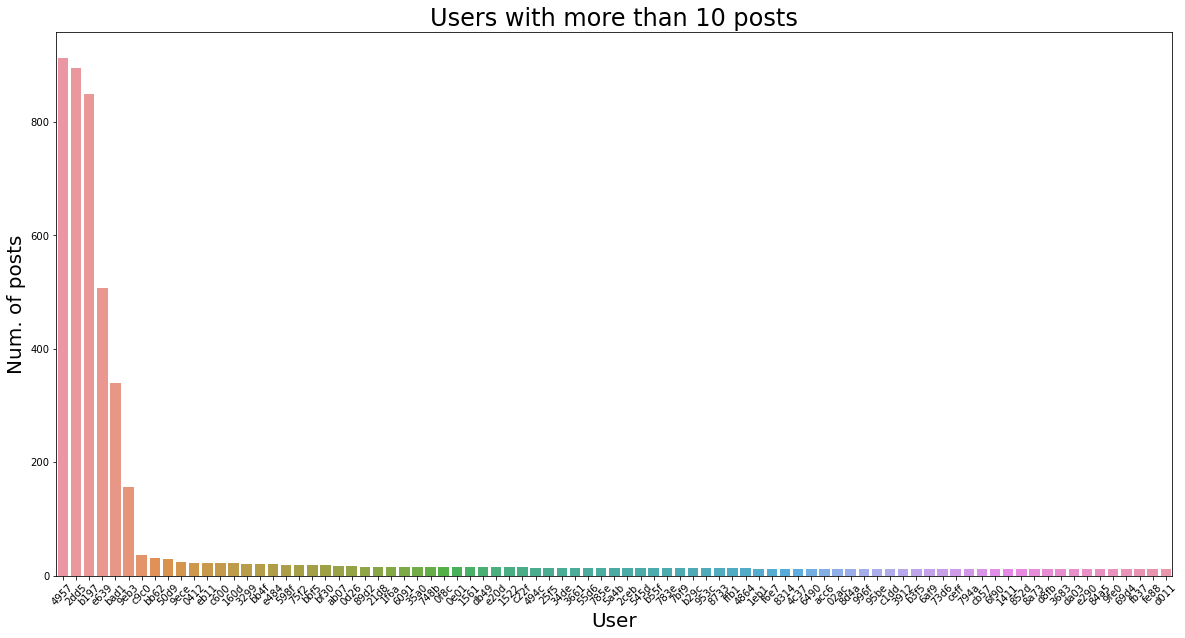

In [40]:
plt.figure(figsize=(20,10))
g = sns.barplot(x='user', y='post_count', data=users_posts)
for item in g.get_xticklabels():
    item.set_rotation(45)
plt.xlabel("User", size=20)
plt.ylabel("Num. of posts", size=20)
plt.title("Users with more than 10 posts", size=24)

We can see that there are a few very active users.

In [41]:
# Visualize the frquencies of bigger controversy scores.
controversy_posts = df[~df.controversy.isnull()].copy()
controversy_posts.controversy = controversy_posts.controversy.apply(lambda x: math.floor(x))
keys = list(controversy_posts.controversy.value_counts().keys())
values = controversy_posts.controversy.value_counts().values

controversy_posts =  pd.DataFrame({'controversy': keys, 'post_count': values})
controversy_posts = controversy_posts[controversy_posts.controversy > 0]

Text(0.5, 1.0, 'Number of posts + comments per controversy score')

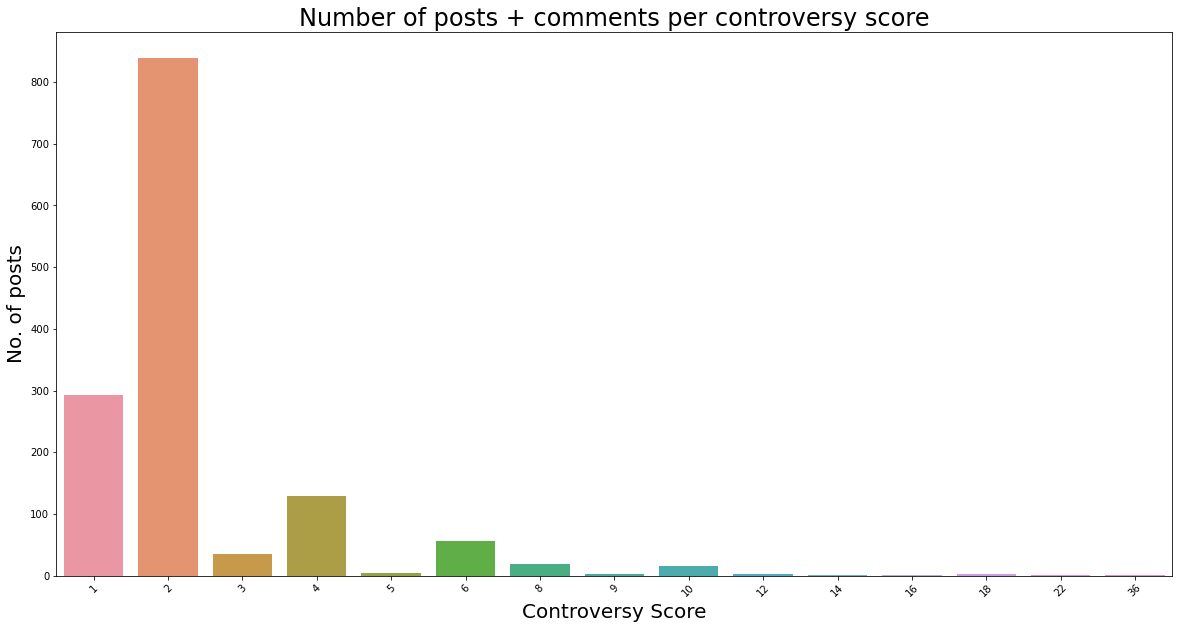

In [42]:
plt.figure(figsize=(20,10))
g = sns.barplot(x='controversy', y='post_count', data=controversy_posts)
for item in g.get_xticklabels():
    item.set_rotation(45)
plt.xlabel("Controversy Score", size=20)
plt.ylabel("No. of posts", size=20)
plt.title("Number of posts + comments per controversy score", size=24)

We can see that most posts are not very controversial, however there are few posts with a high controversy score.

In [43]:
# Visualize most frequent hashtags.
keys = hashtags_df.body.str.lower().str.extractall(r'(\#\w+)')[0].value_counts().keys()
values = hashtags_df.body.str.lower().str.extractall(r'(\#\w+)')[0].value_counts().values

# Store the frequency of each hashtag and then plot a histogram.
hashtag_freq = dict(zip(keys, values))

# Show hashtags with a frequency higher than 50.
top_hashtag_freq = dict((k, v) for k, v in hashtag_freq.items() if v >= 50)
top_hashtag_freq

{'#trump2020': 290,
 '#maga': 167,
 '#stopthesteal': 160,
 '#wwg1wga': 107,
 '#trump': 87,
 '#qanon': 68,
 '#kag': 55,
 '#obamagate': 54}

Text(0.5, 1.0, 'Top Hashtags Frequencies')

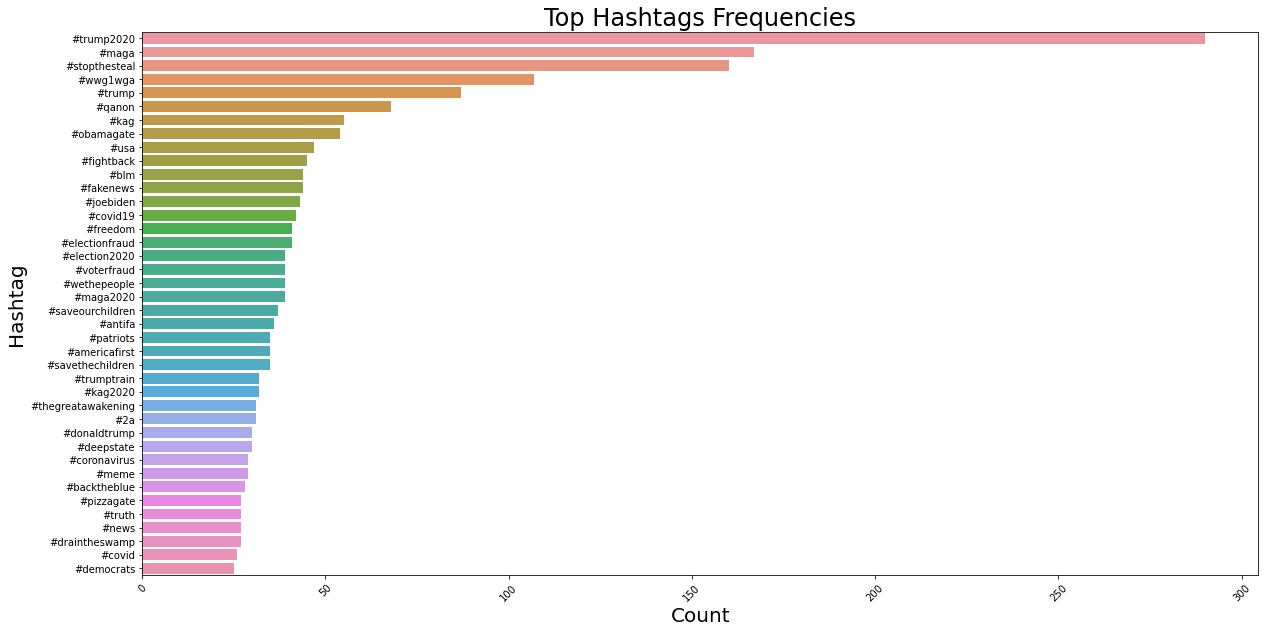

In [44]:
hashtag_counts_df = pd.DataFrame({'hashtag': keys[:40], 'hashtag_count': values[:40]}).sort_values(by='hashtag_count', ascending=False)
plt.figure(figsize=(20,10))

g = sns.barplot(x='hashtag_count', y='hashtag', data=hashtag_counts_df, orient='h')
for item in g.get_xticklabels():
    item.set_rotation(45)
plt.xlabel("Count", size=20)
plt.ylabel("Hashtag", size=20)
plt.title("Top Hashtags Frequencies", size=24)

We can see that the most popular hashtags are about Trump, Make America Great Again (MAGA), USA, patriotism and the election of 2020. Also, the fact that Parler has become an echo room for right wing extremmists is illustrated by hashtags that repeat famous statements of political leaders such as #maga (Make America Great Again) and #stopthesteal which are the 2nd and 3rd most frequent trump-related hashtags.

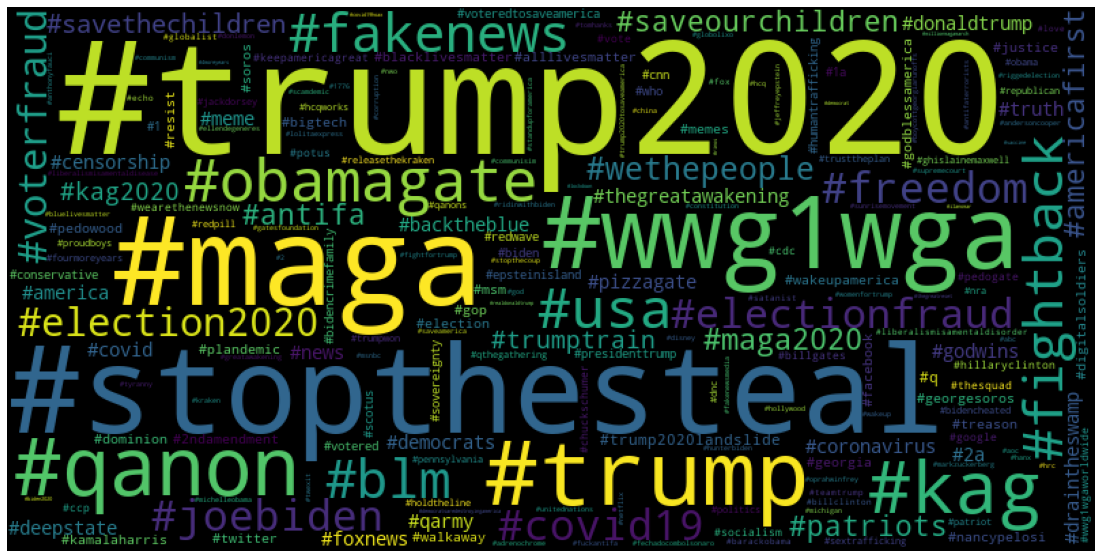

In [45]:
# Plot wordclowd of the hashtags.
wordcloud_hashtags = WordCloud(width=800, height=400, stopwords=STOPWORDS).generate_from_frequencies(hashtag_freq)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud_hashtags)
plt.axis("off")
plt.show()

In [46]:
def preprocessing(hashtag_list):
    """Preprocess hashtag terms to single string."""
    tokens = ast.literal_eval(hashtag_list)
    
    # Convert list to a sentence string.
    sent = ' '.join(tokens)
    
    # Tokenize.
    tokens = nltk.tokenize.word_tokenize(sent)
    
    # Lowercase()
    tokens = [token.lower() for token in tokens]
    
    # Check if alphanumeric.
    tokens = [token for token in tokens if token.isalnum()]

    # Cleaned sentence.
    clean_sentence = ''
    clean_sentence = ' '.join(token for token in tokens)
    return clean_sentence

In [47]:
hashtags_df['hashtags_str'] = hashtags_df['hashtags'].apply(preprocessing)

In [48]:
hashtags_df.head()

Unnamed: 0  comments                                               body  \
104   1056328.0       9.0  #trump2020 #womenfortrump #presidenttrump #bes...   
136    642011.0       0.0                           Son of #TraitorTrash. 🙄🖕   
162     28801.0       0.0  Weapon used in nuclear scientist's assassinati...   
181    801140.0       0.0  God bless this woman & her team🇺🇸 #stopthestea...   
215   1084079.0      -1.0  Classic!😂😂😂\n#teamtrump #fyp #rudygiuliani #tr...   

                                          bodywithurls     createdAt  \
104  #trump2020 #womenfortrump #presidenttrump #bes...  2.020091e+13   
136                         Son of #TraitorTrash. 🙄🖕\n  2.020122e+13   
162  Weapon used in nuclear scientist's assassinati...  2.020113e+13   
181  God bless this woman & her team🇺🇸 #stopthestea...  2.020120e+13   
215  Classic!😂😂😂\n#teamtrump #fyp #rudygiuliani #tr...  2.020112e+13   

          createdAtformatted                           creator  datatype  \
104  2020-09-10 03:25:26 UTC  711b852eda514c67816067c907a600d1     posts   
136  2020-12-17 02:04:41 UTC  cad4fbe7ab4f46a9a5b00a1fef4f3734  comments   
162  2020-11-30 21:49:10 UTC  e5b60882be8641a496b968e6ba6c321e     posts   
181  2020-12-01 03:03:47 UTC  7ec64fcd448d43ee8f9b83f6a93bc9c0  comments   
215  2020-11-20 16:25:05 UTC  a964d7c7b1a4453a9202f224ce3817f9     posts   

     depth  depthRaw  ...  controversy  conversation downvotes  \
104    0.0       0.0  ...          NaN           NaN       NaN   
136    1.0       1.0  ...          0.0           NaN       0.0   
162    0.0       0.0  ...          NaN           NaN       NaN   
181    1.0       1.0  ...          0.0           NaN       0.0   
215    0.0       0.0  ...          NaN           NaN       NaN   

                                 post score isPrimary  replyingTo  \
104                               NaN   NaN       NaN         NaN   
136  9570dae20e364b06a1232e0ef622e35f   3.0       1.0         NaN   
162                               NaN   NaN       NaN         NaN   
181  19cbe0c04077423fa3d2a7a790d82d0f  19.0       1.0         NaN   
215                               NaN   NaN       NaN         NaN   

                                             hashtaghs  hashtags_no  \
104  [#trump2020, #womenfortrump, #presidenttrump, ...            5   
136                                    [#TraitorTrash]            1   
162  [#Israel, #IranianNuclearScientist, #MohsenFak...            4   
181   [#stopthesteal, #stopthesteal2020, #stopthecoup]            3   
215  [#teamtrump, #fyp, #rudygiuliani, #trump2020, ...           14   

                                          hashtags_str  
104  trump2020 womenfortrump presidenttrump bestpre...  
136                                       traitortrash  
162  israel iraniannuclearscientist mohsenfakhrizad...  
181          stopthesteal stopthesteal2020 stopthecoup  
215  teamtrump fyp rudygiuliani trump2020 stopthest...  

[5 rows x 42 columns]

In [52]:
# Convert a collection of text documents to a matrix of token counts.
cv = CountVectorizer(ngram_range=(1,1), stop_words='english')

# Matrix of token counts.
X = cv.fit_transform(hashtags_df['hashtags_str'].tolist())
Xc = (X.T * X) # matrix manipulation
Xc.setdiag(0) # set the diagonals to be zeroes as it's pointless to be 1

In [53]:
names = cv.get_feature_names() # This are the entity names (i.e. keywords)
co_occurence_df = pd.DataFrame(data=Xc.toarray(), columns=names, index=names)

In [54]:
top_hashtags = hashtag_counts_df.hashtag.apply(lambda x: x.strip('#')).tolist()

In [55]:
heatmap_df = co_occurence_df.loc[top_hashtags, top_hashtags]

<AxesSubplot:>

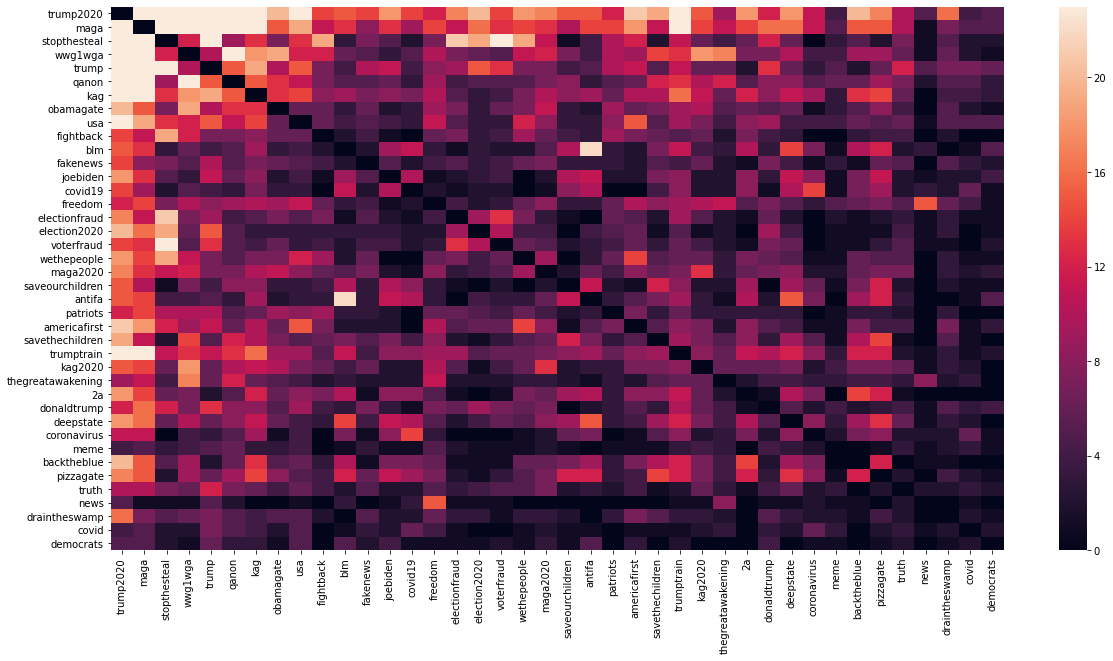

In [56]:
# Co-occurence heatmap for top hashtags.
plt.figure(figsize=(20,10))
sns.heatmap(heatmap_df, robust=True)

We can see that indeed hashtags related to the same topics tend to co-occur in posts/comments, especially Trump-related ones.

In [57]:
df.body = df.body.apply(str)

In [58]:
# Now analyze body terms.

# Remove digits and words containing digits.
df['tokens'] = df['body'].apply(lambda x: re.sub('\w*\d\w*',' ', x))

# Remove end of line character.
df['tokens'] = df['tokens'].apply(lambda x: re.sub('\s+',' ', x))

# Remove punctuation.
df['tokens'] = df['tokens'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x))

# Remove redundant empty spaces.
df['tokens'] = df['tokens'].apply(lambda x: re.sub(' +',' ',x))

# Lowercase text,
df['tokens'] = df['tokens'].apply(lambda x: x.lower())

# Get English stopwords.
stop = stopwords.words('english') 
stop = stop + ['like', 'also', 'hence', 'therefore', 'haha', 'hahaha', 'lol', '', 'ok']

# Split body text terms into lists
df['tokens'] = df['tokens'].str.lower().str.split()

# Remove stop words.
df['tokens'] = df['tokens'].apply(lambda x: [item for item in x if item not in stop])

# Keep only wordes longer than 3 character.
df['tokens'] = df['tokens'].apply(lambda x: [item for item in x if len(item) > 4])

df[['body', 'tokens']].head()

body  \
3     Liberalism really is a mental disorder 😂😇🙏🏼🇺🇸🇺🇸   
5   ‘October Surprise’: New details emerge about F...   
8   People like this see all the problems of man a...   
9   So your saying you are a very loyal lady! Good...   
10  go to web site recallgavin search engine can g...   

                                               tokens  
3    [liberalism, really, mental, disorder, 😂😇🙏🏼🇺🇸🇺🇸]  
5   [‘october, surprise’, details, emerge, delay, ...  
8   [people, problems, believe, address, global, o...  
9          [saying, loyal, silent, majority, pleased]  
10  [recallgavin, search, engine, guide, print, pe...

In [59]:
keys = df.tokens.explode().value_counts().keys()
values = df.tokens.explode().value_counts().values

# Store the frequency of each term and then plot a histogram.
tokens_freq = dict(zip(keys, values))

# Show terms witha frequency higher than 50.
top_tokens_freq = dict((k, v) for k, v in tokens_freq.items() if v >= 1000)
top_tokens_freq

{'parler': 4696,
 'people': 4493,
 'trump': 4443,
 'right': 3522,
 'looking': 2407,
 'great': 2322,
 'forward': 2300,
 'welcome': 2246,
 'would': 2138,
 'president': 2079,
 'biden': 1938,
 'alive': 1877,
 'everyone': 1802,
 'america': 1725,
 'truth': 1674,
 'don’t': 1595,
 'think': 1574,
 'share': 1543,
 'election': 1507,
 'going': 1434,
 'follow': 1423,
 'joined': 1329,
 'country': 1291,
 'actually': 1288,
 'meeting': 1280,
 'never': 1231,
 'speech': 1185,
 'fighting': 1131,
 'given': 1093,
 'democrats': 1040,
 'constitutional': 1010,
 'liberty': 1006,
 'special': 1002,
 'thank': 1000}

Text(0.5, 1.0, 'Top Terms Frequencies')

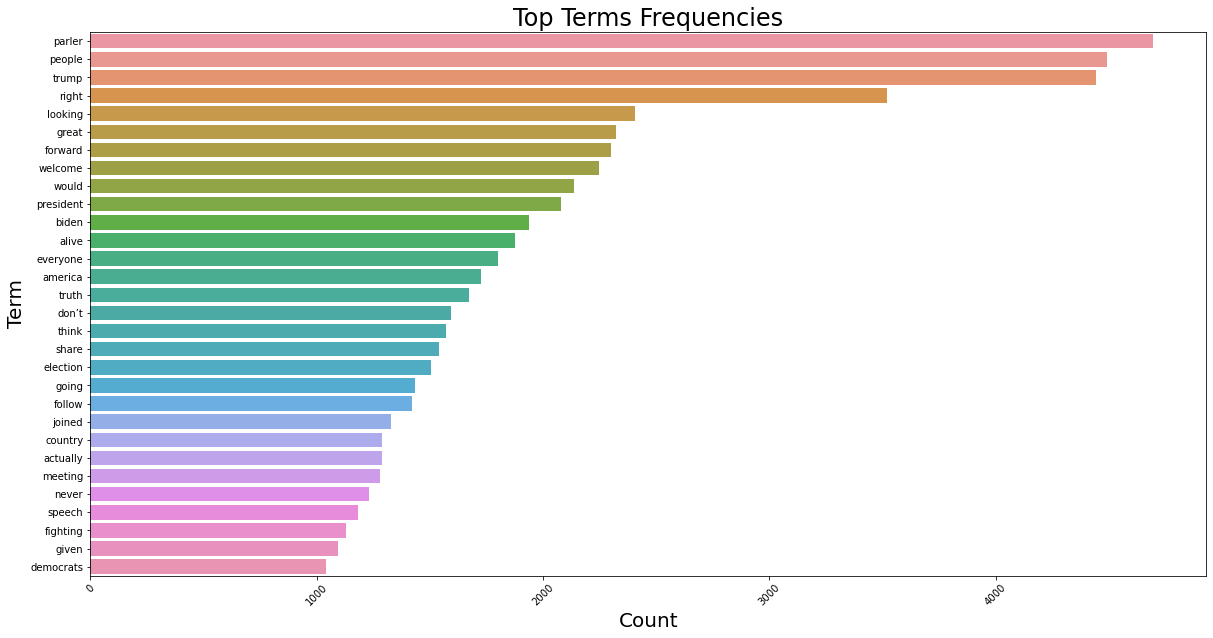

In [60]:
term_counts_df = pd.DataFrame({'term': keys[:30], 'term_count': values[:30]}).sort_values(by='term_count', ascending=False)
plt.figure(figsize=(20,10))
g = sns.barplot(x='term_count', y='term', data=term_counts_df, orient='h')
for item in g.get_xticklabels():
    item.set_rotation(45)
plt.xlabel("Count", size=20)
plt.ylabel("Term", size=20)
plt.title("Top Terms Frequencies", size=24)

We can see the posts and comments also contain mostly terms about trump, election, and politics. Yet again, supporting the political echo room theory.

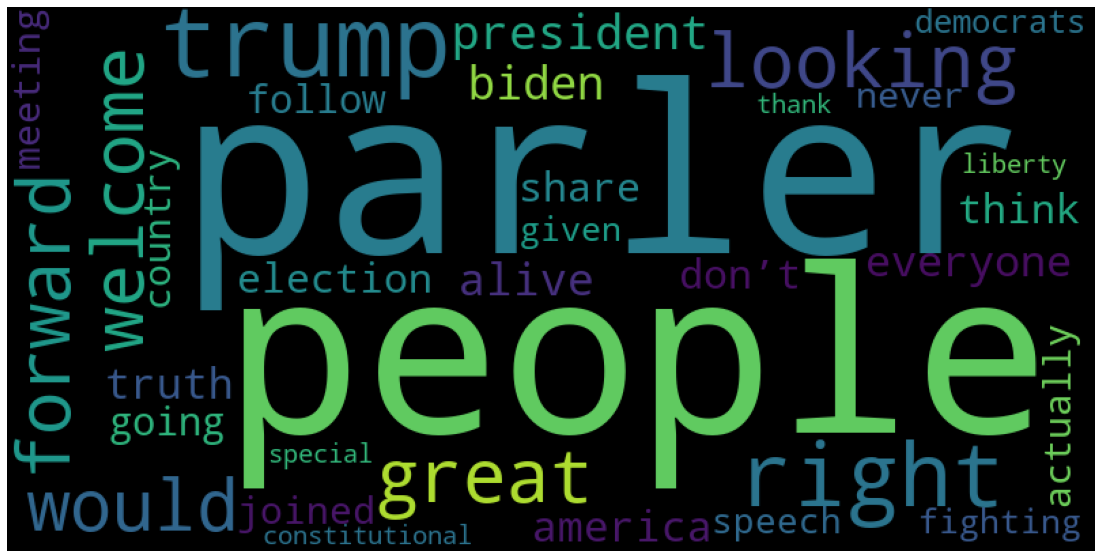

In [61]:
# Plot wordclowd of the terms.
wordcloud_terms = WordCloud(width=800, height=400, stopwords=STOPWORDS).generate_from_frequencies(top_tokens_freq)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud_terms)
plt.axis("off")
plt.show()

In [62]:
# Convert to datetime object.
hashtags_df['createdAtformatted'] = pd.to_datetime(hashtags_df['createdAtformatted'])
df['createdAtformatted'] = pd.to_datetime(df['createdAtformatted'])

# Store only the date (without time).
hashtags_df['date'] = hashtags_df['createdAtformatted'].dt.date
df['date'] = df['createdAtformatted'].dt.date

# Store only the time: hour and minute.
hashtags_df['hour'] = hashtags_df['createdAtformatted'].dt.hour
hashtags_df['minute'] = hashtags_df['createdAtformatted'].dt.minute
df['hour'] = hashtags_df['createdAtformatted'].dt.hour
df['minute'] = hashtags_df['createdAtformatted'].dt.minute

In [63]:
df.head(3)

Unnamed: 0  comments                                               body  \
3    446167.0       0.0    Liberalism really is a mental disorder 😂😇🙏🏼🇺🇸🇺🇸   
5     74195.0       2.0  ‘October Surprise’: New details emerge about F...   
8    753995.0       1.0  People like this see all the problems of man a...   

                                        bodywithurls     createdAt  \
3  Liberalism really is a mental disorder 😂😇🙏🏼🇺🇸🇺🇸\n  2.020101e+13   
5  ‘October Surprise’: New details emerge about F...  2.020092e+13   
8  People like this see all the problems of man a...  2.020082e+13   

         createdAtformatted                           creator  datatype  \
3 2020-10-10 21:47:10+00:00  2ca15d77516344728f6f23405cebf1c3  comments   
5 2020-09-20 11:28:58+00:00  c271f1bbe74f45bf84b9b47c55a49628     posts   
8 2020-08-21 11:05:12+00:00  e31446fc99474fcf98a1ff732eb0167e  comments   

   depth  depthRaw  ...  downvotes                              post score  \
3    1.0       1.0  ...        0.0  c281bb4cd8d942c29eb9ec9f74689686   0.0   
5    0.0       0.0  ...        NaN                               NaN   NaN   
8    1.0       1.0  ...        0.0  181868ef66624d24908fa0ef9ad55532  12.0   

  isPrimary replyingTo hashtaghs  \
3       1.0        NaN        []   
5       NaN        NaN        []   
8       1.0        NaN        []   

                                              tokens        date  hour  minute  
3   [liberalism, really, mental, disorder, 😂😇🙏🏼🇺🇸🇺🇸]  2020-10-10   NaN     NaN  
5  [‘october, surprise’, details, emerge, delay, ...  2020-09-20   NaN     NaN  
8  [people, problems, believe, address, global, o...  2020-08-21   NaN     NaN  

[3 rows x 44 columns]

Text(0.5, 1.0, 'Total num. of hashtags per day')

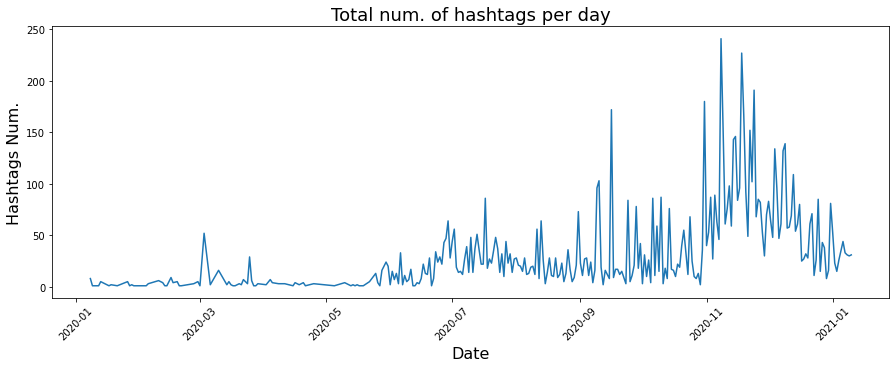

In [64]:
# Plot time series of number of hashtags per date/day.
hashtags_per_day = hashtags_df.groupby('date')['hashtags_no'].sum()
hashtags_per_day.reset_index().sort_values(by='date', ascending=True).plot(figsize=(15,5), x='date', y='hashtags_no', rot=45, legend=False)
plt.xlabel("Date",size=16)
plt.ylabel("Hashtags Num.",size=16)
plt.title("Total num. of hashtags per day", size=18)

We can see how the numbers of hashtags published per day increased around key events such as 4th of July (Independence Day), 3rd of November (USA Elecionsfor example), and the 6th of January 2021 (Capitol Raid).

<Figure size 432x288 with 0 Axes>

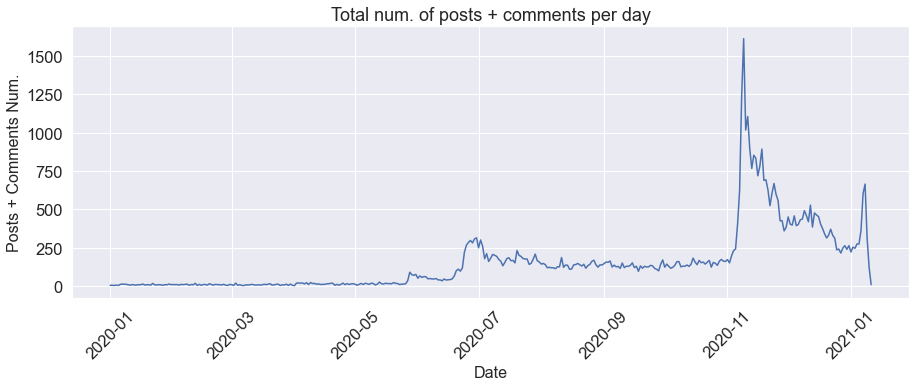

In [65]:
# Plot time series of number of posts + comments per date.
sns.set(font_scale=1.5)
plt.gcf().subplots_adjust(bottom=0.15)
post_comm_per_day = df.groupby('date').size()
post_comm_per_day.reset_index().sort_values(by='date', ascending=True).plot(figsize=(15,5), x='date', rot=45, legend=False)
plt.xlabel("Date",size=16)
plt.ylabel("Posts + Comments Num.",size=16)
plt.title("Total num. of posts + comments per day", size=18)
plt.savefig("posts_day.png", dpi=50)

We can see how the numbers of posts and comments published per day increased around key events such as 4th of July (Independence Day), 3rd of November (USA Elecionsfor example) and the 6th of January 2021 (Capitol Raid).

Text(0.5, 1.0, 'Total num. of posts per day')

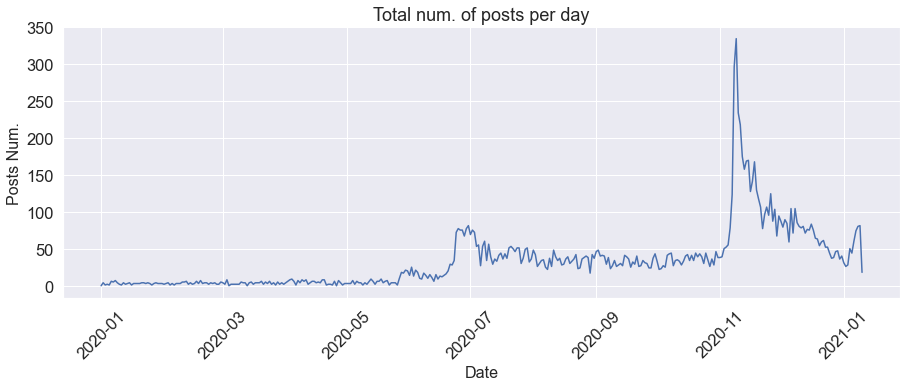

In [66]:
# Plot time series of number of posts per date.
posts_per_day = df[df.datatype == 'posts'].groupby('date').size()
posts_per_day.reset_index().sort_values(by='date', ascending=True).plot(figsize=(15,5), x='date', rot=45, legend=False)
plt.xlabel("Date",size=16)
plt.ylabel("Posts Num.",size=16)
plt.title("Total num. of posts per day", size=18)

Text(0.5, 1.0, 'Total num. of comments per day')

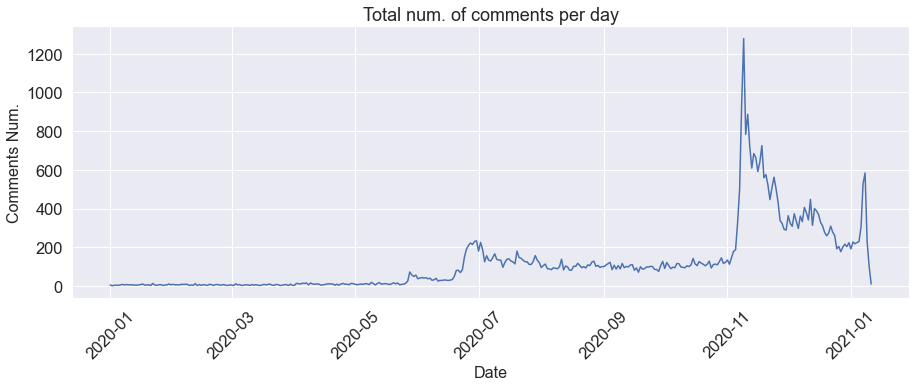

In [67]:
# Plot time series of number of comments per date.
coms_per_day = df[df.datatype == 'comments'].groupby('date').size()
coms_per_day.reset_index().sort_values(by='date', ascending=True).plot(figsize=(15,5), x='date', rot=45, legend=False)
plt.xlabel("Date",size=16)
plt.ylabel("Comments Num.",size=16)
plt.title("Total num. of comments per day", size=18)

In [68]:
# Day of the capitol raid.
raid_date = datetime.date(2021, 1, 6)

# Keep only entries on the capitol day raid.
capitol_storm_df = df[df.date == raid_date]
capitol_storm_df.head()

hashtags_capitol_storm_df = hashtags_df[hashtags_df.date == raid_date]
hashtags_capitol_storm_df.head()

Unnamed: 0  comments  \
884      530853.0      -1.0   
2691     810257.0      -1.0   
4930     472054.0      -1.0   
21308    780000.0      -1.0   
25222    540101.0      -1.0   

                                                    body  \
884    As a Straight Christian Conservative Patriot a...   
2691   Those buildings in DC are OURS!!! God bless AL...   
4930                                     #removeallrinos   
21308                                  #TraitorMikePence   
25222  #SaveAmerica #SayIt #Pray #LetRoll #PatriotsAr...   

                                            bodywithurls     createdAt  \
884    As a Straight Christian Conservative Patriot a...  2.021011e+13   
2691   Those buildings in DC are OURS!!! God bless AL...  2.021011e+13   
4930                                   #removeallrinos\n  2.021011e+13   
21308                                #TraitorMikePence\n  2.021011e+13   
25222  #SaveAmerica #SayIt #Pray #LetRoll #PatriotsAr...  2.021011e+13   

             createdAtformatted                           creator  datatype  \
884   2021-01-06 20:21:35+00:00  584d115f0fa345a4801f72687c6d9b1c  comments   
2691  2021-01-06 19:46:12+00:00  b8fbf99dfcd84a9184ce756a81e9bd27  comments   
4930  2021-01-06 01:35:08+00:00  3abed29e50354e979f6494fa178031cf  comments   
21308 2021-01-06 20:49:32+00:00  72dc1aa3c6a149fa9d3e38a96bb07d1f  comments   
25222 2021-01-06 15:15:58+00:00  7cfb58f93a674483be3ee1abaaa47752  comments   

       depth  depthRaw  ...                              post  score  \
884      1.0       1.0  ...  4631d8228dc3476fb5e9af835dec14df    8.0   
2691     1.0       1.0  ...  a005ee4a6bcf4df5a8bd93c7a7620112    3.0   
4930     1.0       1.0  ...  b81bd1e03826492095f3ac0184862be7    2.0   
21308    1.0       1.0  ...  58bf424c16974a848c282523757576a1    2.0   
25222    1.0       1.0  ...  fab25cf0cef649b2ba0fd36601a3da86    1.0   

      isPrimary replyingTo                                          hashtaghs  \
884         1.0        NaN  [#WeThePeopleArePatriotsTheNextGeneration, #Wa...   
2691        1.0        NaN                     [#Patriots, #ForGodAndCountry]   
4930        1.0        NaN                                  [#removeallrinos]   
21308       1.0        NaN                                [#TraitorMikePence]   
25222       1.0        NaN  [#SaveAmerica, #SayIt, #Pray, #LetRoll, #Patri...   

      hashtags_no                                       hashtags_str  \
884             3  wethepeoplearepatriotsthenextgeneration walkaw...   
2691            2                          patriots forgodandcountry   
4930            1                                     removeallrinos   
21308           1                                   traitormikepence   
25222           7  saveamerica sayit pray letroll patriotsarise w...   

             date  hour  minute  
884    2021-01-06    20      21  
2691   2021-01-06    19      46  
4930   2021-01-06     1      35  
21308  2021-01-06    20      49  
25222  2021-01-06    15      15  

[5 rows x 45 columns]

Text(0.5, 1.0, 'Total num. of posts + comments per hour')

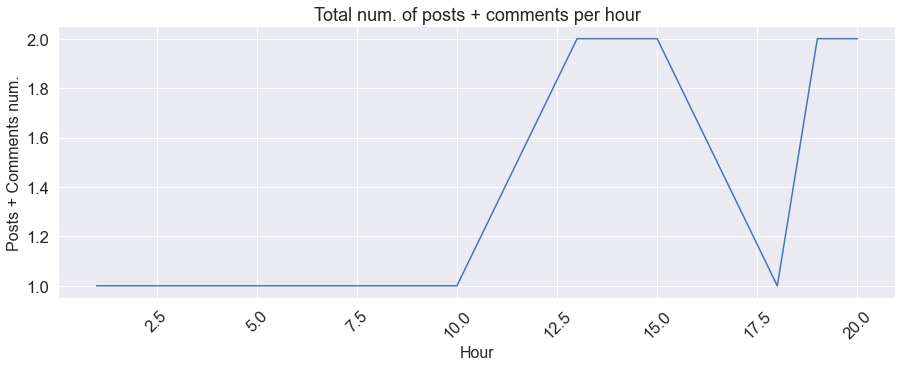

In [98]:
# Plot time series of number of posts + comments per hour on the day of the capitol raid .
comms_per_hour_raid = capitol_storm_df.groupby('hour').size()
comms_per_hour_raid.reset_index().sort_values(by='hour', ascending=True).plot(figsize=(15,5), x='hour', rot=45, legend=False)
plt.xlabel("Hour",size=16)
plt.ylabel("Posts + Comments num.",size=16)
plt.title("Total num. of posts + comments per hour", size=18)

The plot makes sense since the mob of people entered the building around 2:15 pm and everything ended around 5 pm. The plummeting part might be due to the supporters going home and being on the road. The activity resumed in the evenings as people were discussing the events.

Text(0.5, 1.0, 'Total num. of hashtags per hour')

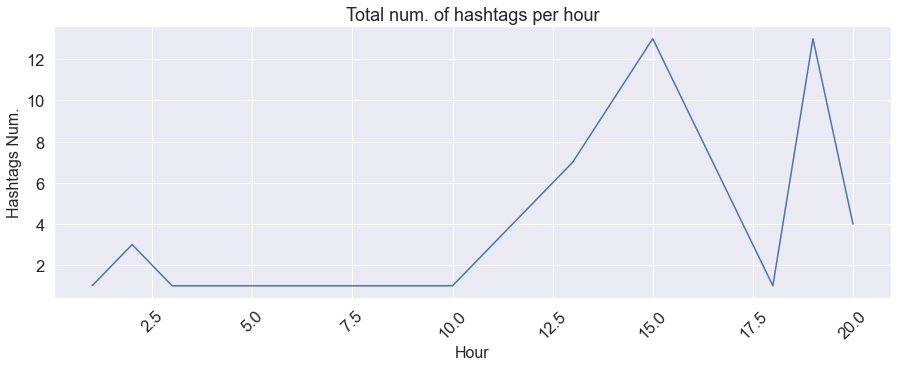

In [70]:
# Plot time series of number of hashtags per hour on the day of the capitol raid .
hashtags_per_hour_raid = hashtags_capitol_storm_df.groupby('hour')['hashtags_no'].sum()
hashtags_per_hour_raid.reset_index().sort_values(by='hour', ascending=True).plot(figsize=(15,5), x='hour', y='hashtags_no', rot=45, legend=False)
plt.xlabel("Hour",size=16)
plt.ylabel("Hashtags Num.",size=16)
plt.title("Total num. of hashtags per hour", size=18)

A similar trend can be seen in therms of number of posted hashtags per hour on the day of the Capitol Raid.

# Topic Modelling

In [71]:
# NLTK Stop words
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'op', 'ikr', 'ok', 'like', 'well', 'lol'])

In [72]:
docs = df.body.tolist()

In [73]:
# Convert to list
data = docs

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]


def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

data = [deEmojify(sent).strip() for sent in data]

pprint(data[:1])

['Liberalism really is a mental disorder']


In [74]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['liberalism', 'really', 'is', 'mental', 'disorder']]


In [75]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['liberalism', 'really', 'is', 'mental_disorder']


In [76]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [77]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Form Trigrams
data_words_trigrams = make_trigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams,  allowed_postags=['NOUN'])#allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['liberalism']]


In [78]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1)]]


In [79]:
coherence_scores = []
perplexities = []
for topic in range(20, 40):
    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=topic, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    
    
    # Compute Perplexity
    perplexities.append((topic,lda_model.log_perplexity(corpus) ))

    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_scores.append((topic, coherence_lda))

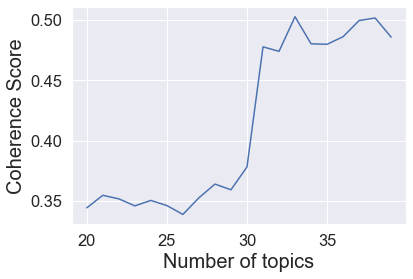

In [80]:
plt.plot(*zip(*coherence_scores))
plt.xlabel("Number of topics", size=20)
plt.ylabel("Coherence Score", size=20)
plt.show()

We can see 31 topics lead to the highest coherence score.

In [81]:
coherence_scores

[(20, 0.34433430783108465),
 (21, 0.35473970611896094),
 (22, 0.3517881285322439),
 (23, 0.3459868631821831),
 (24, 0.35048552208011813),
 (25, 0.3462291150354535),
 (26, 0.33888512888986927),
 (27, 0.35266599683750016),
 (28, 0.36404033295204197),
 (29, 0.35932027614899914),
 (30, 0.3782218973054732),
 (31, 0.4778370410546478),
 (32, 0.4741268764697239),
 (33, 0.5027946715055133),
 (34, 0.48034667530138314),
 (35, 0.4799519632924101),
 (36, 0.4862675180971363),
 (37, 0.4996389987866893),
 (38, 0.5017646379561974),
 (39, 0.485880937724907)]

In [82]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=31, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(21,
  '0.000*"mood" + 0.000*"primer" + 0.000*"nasalie" + 0.000*"secretsocietie" + '
  '0.000*"truthbomb" + 0.000*"impunity" + 0.000*"conditioning" + '
  '0.000*"european" + 0.000*"suckwit" + 0.000*"lap"'),
 (14,
  '0.000*"mood" + 0.000*"primer" + 0.000*"nasalie" + 0.000*"secretsocietie" + '
  '0.000*"truthbomb" + 0.000*"impunity" + 0.000*"conditioning" + '
  '0.000*"european" + 0.000*"suckwit" + 0.000*"lap"'),
 (2,
  '0.000*"mood" + 0.000*"primer" + 0.000*"nasalie" + 0.000*"secretsocietie" + '
  '0.000*"truthbomb" + 0.000*"impunity" + 0.000*"conditioning" + '
  '0.000*"european" + 0.000*"suckwit" + 0.000*"lap"'),
 (19,
  '0.000*"mood" + 0.000*"primer" + 0.000*"nasalie" + 0.000*"secretsocietie" + '
  '0.000*"truthbomb" + 0.000*"impunity" + 0.000*"conditioning" + '
  '0.000*"european" + 0.000*"suckwit" + 0.000*"lap"'),
 (6,
  '0.000*"mood" + 0.000*"primer" + 0.000*"nasalie" + 0.000*"secretsocietie" + '
  '0.000*"truthbomb" + 0.000*"impunity" + 0.000*"conditioning" + '
  '0.000*"europea

The main topics can be visualised beneath as wordclowds.

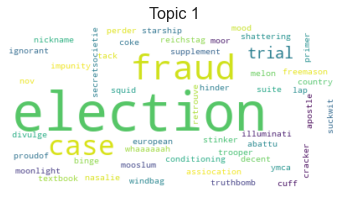

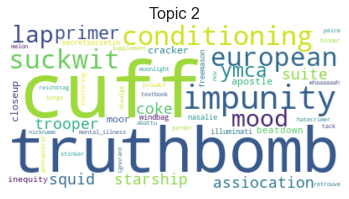

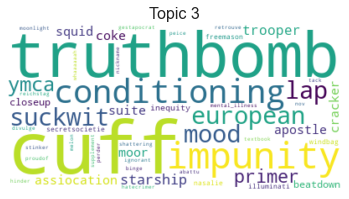

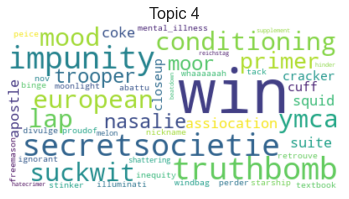

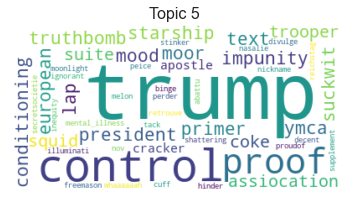

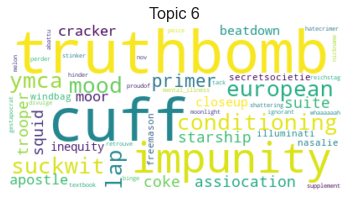

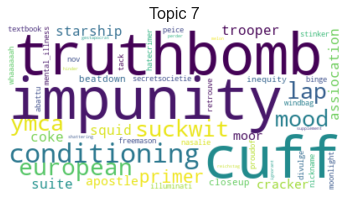

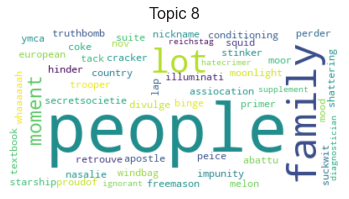

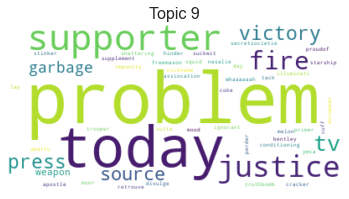

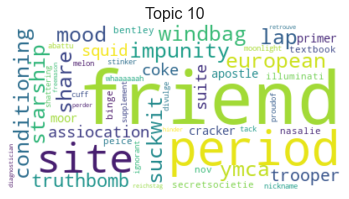

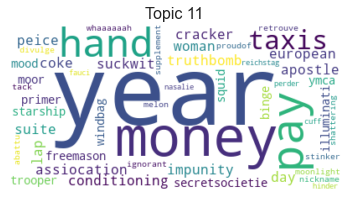

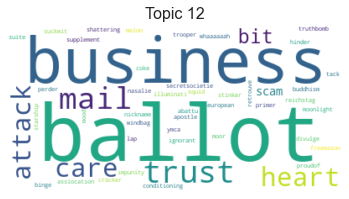

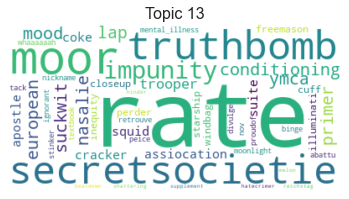

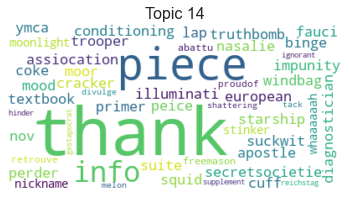

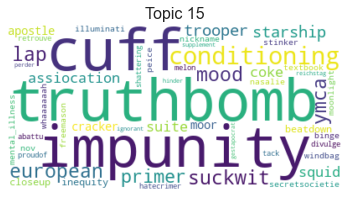

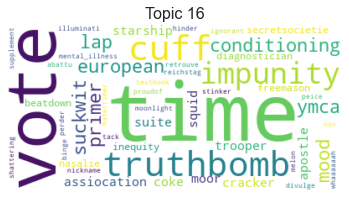

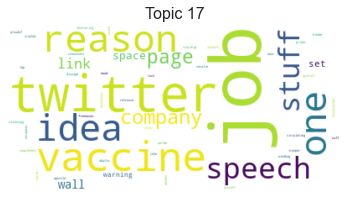

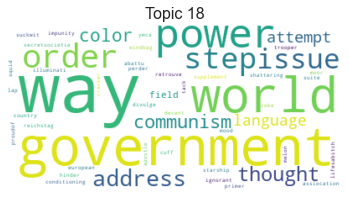

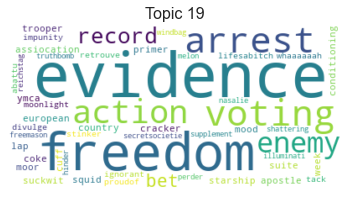

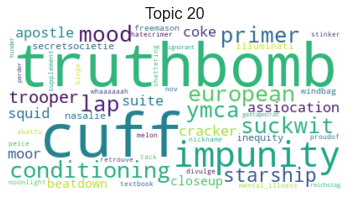

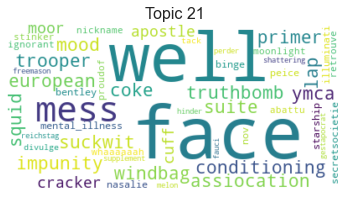

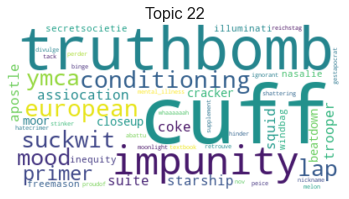

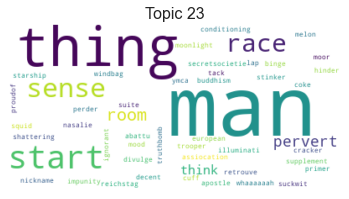

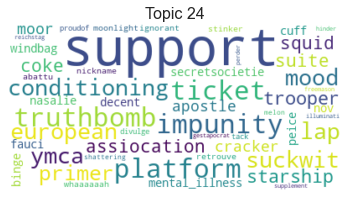

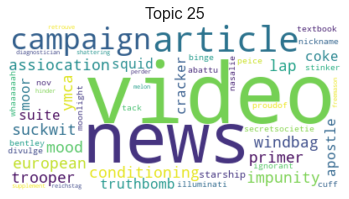

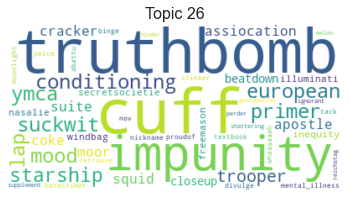

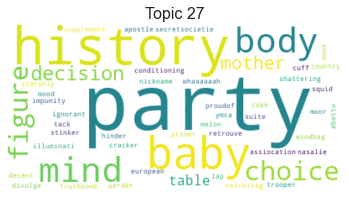

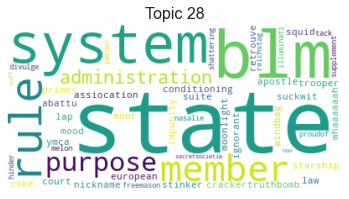

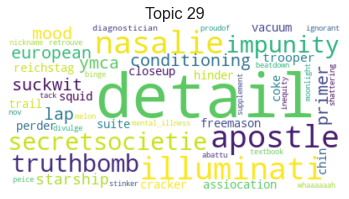

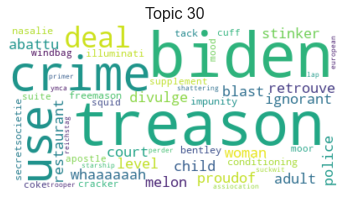

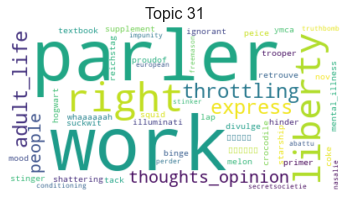

In [83]:
topic = 0 # Initialize counter
while topic < 31:
    # Get topics and frequencies and store in a dictionary structure
    topic_words_freq = dict(lda_model.show_topic(topic, topn=50))
    
    # Generate Word Cloud for topic using frequencies
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(topic_words_freq)
    topic += 1
    plt.gca().set_title('Topic ' + str(topic), fontdict=dict(size=16))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Sentiment Analysis

In [84]:
def get_sentiment(text, analyzer):
    """Compute the sentiment label of a document
    based on a given VADER analyzer.
    
    Args:
        text: A given text document.
        analyzer: VADER analyser for sentiment analysy.
    Returns:
        A string representing the identified sentiment
        based on the compound score returned by the analyser.
        Possible values are: 'Positive', 'Negative' or
        'Neutral'.
    """

    compound_score = analyzer.polarity_scores(text)['compound']
    
    if compound_score  >= 0.05:
        return 'positive'
    
    if compound_score < -0.05:
        return 'negative'
    
    return 'neutral'


# Download the lexicon for VADER unsupervised
# sentiment analyzer.
nltk.download('vader_lexicon')

analyzer = SentimentIntensityAnalyzer()

# Compute and store the sentiment for each post/comment.
df['sentiment'] = df['body'].apply(
    lambda x: get_sentiment(x, analyzer)
    )

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/iuliana/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Text(0.5, 1.0, 'Total num. of posts/comments per sentiment')

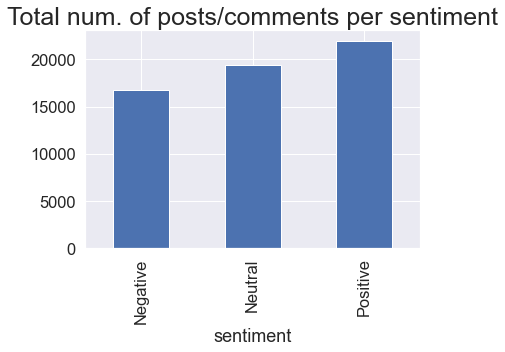

In [85]:
ax = df.groupby(['sentiment']).size().plot.bar()
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
plt.title('Total num. of posts/comments per sentiment', size=25)

Text(0.5, 1.0, 'Posts/comments counts distributions per sentiment')

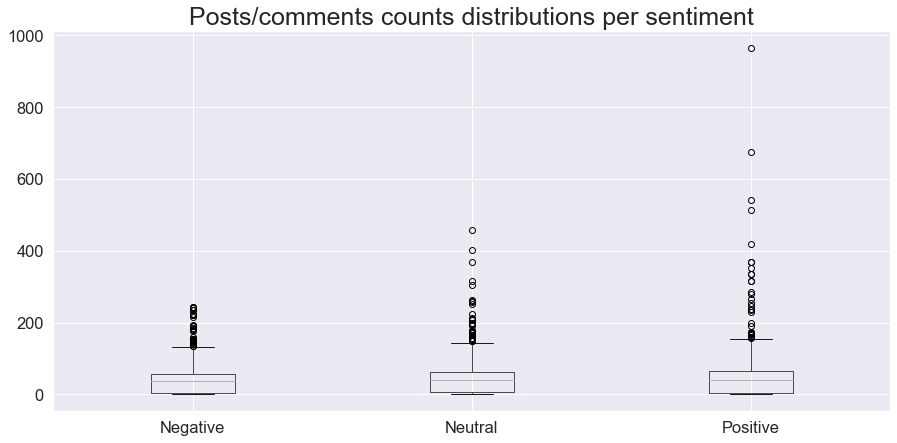

In [86]:
ax = (df.groupby(['sentiment', 'date']).size().to_frame('size')
      .unstack('sentiment').boxplot(figsize=(15, 7)))
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
plt.title('Posts/comments counts distributions per sentiment', size=25)

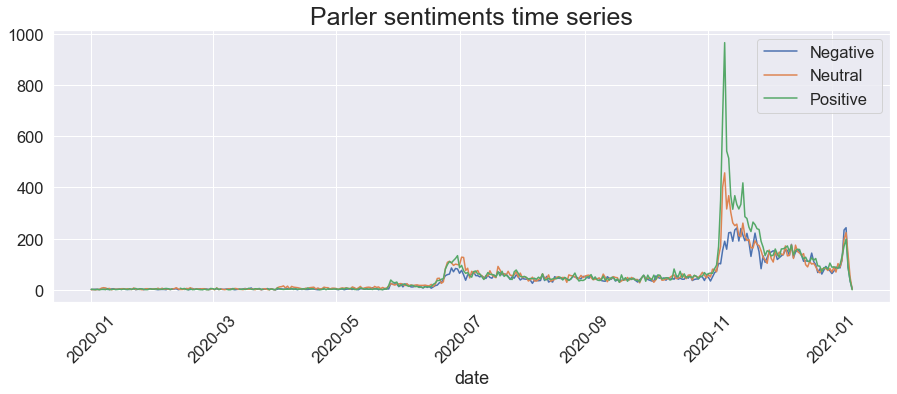

In [87]:
sentiment_counts_per_day = df.groupby(['date', 'sentiment']).size().to_frame('size').unstack('sentiment')
sentiment_counts_per_day.reset_index().sort_values(by='date', ascending=True).plot(figsize=(15,5), x='date', rot=45, legend=False)
plt.title('Parler sentiments time series', size=25)
plt.legend(['Negative', 'Neutral', 'Positive'])

Overall, we can see that positive sentiments dominate the pots, particularly around the election date, when most likely people were expressing their agreement and support for Trump. Furthermore, we can see the peak in the number of negative sentiment posts (the only date negative sentiment posts dominate in terms of number) occurs on the 8th of January, the date coresponding to Trump's ban from Twitter after tweeted posts that might have further instigated violence. In addition to that, the negative sentiment might also be a repecussion of the deaths as a result of the Capitol Asssault.

In [88]:
# Keep only posts and comments with key terms for local sentiment analysis.
trump_term_df = df[df.body.str.lower().str.contains('trump')]
biden_term_df = df[df.body.str.lower().str.contains('biden')]
steal_term_df = df[df.body.str.lower().str.contains('stopthesteal')]

In [89]:
import re

def contains_term(term, sent_list):
    """Keep only sentences that contain the given term."""
    sents = []
    for sent in sent_list:
        if term in sent.lower():
            sents.append(sent)
            
    return '. '.join(sents)

In [90]:
# Keep only sentences containing the term `trump`.
trump_term_df.loc[:, 'trump_sent'] = trump_term_df.body.apply(lambda x: re.split(r'[;!?.\n]+', x))
trump_term_df.loc[:,'trump_sent'] = trump_term_df.trump_sent.apply(lambda x: contains_term('trump', x))

# Compute and store the sentiment for each post/comment.
trump_term_df.loc[:,'sentiment'] = trump_term_df['trump_sent'].apply(
    lambda x: get_sentiment(x, analyzer)
    )

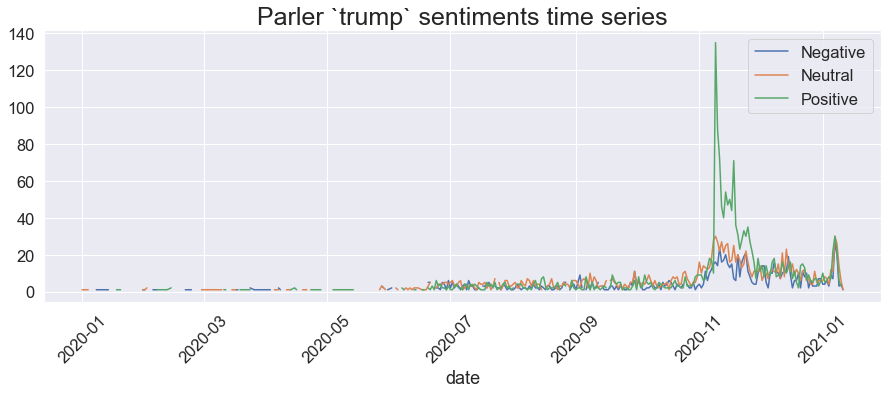

In [92]:
trump_sentiment_counts_per_day = trump_term_df.groupby(['date', 'sentiment']).size().to_frame('size').unstack('sentiment')
trump_sentiment_counts_per_day.reset_index().sort_values(by='date', ascending=True).plot(figsize=(15,5), x='date', rot=45, legend=False)
plt.title('Parler `trump` sentiments time series', size=25)
plt.legend(['Negative', 'Neutral', 'Positive'])

In [94]:
# Keep only sentences containing the term `biden`.
biden_term_df.loc[:, 'biden_sent'] = biden_term_df.body.apply(lambda x: re.split(r'[;!?.\n]+', x))
biden_term_df.loc[:, 'biden_sent'] = biden_term_df.biden_sent.apply(lambda x: contains_term('biden', x))

# Compute and store the sentiment for each post/comment.
biden_term_df.loc[:, 'sentiment'] = biden_term_df['biden_sent'].apply(
    lambda x: get_sentiment(x, analyzer)
    )

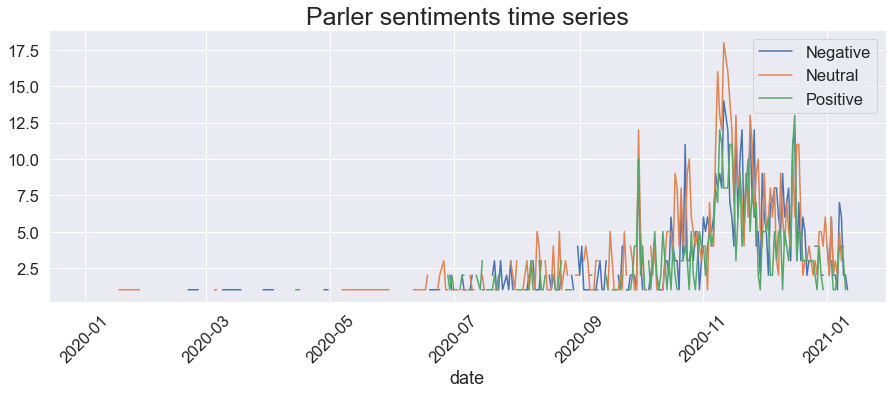

In [95]:
biden_sentiment_counts_per_day = biden_term_df.groupby(['date', 'sentiment']).size().to_frame('size').unstack('sentiment')
biden_sentiment_counts_per_day.reset_index().sort_values(by='date', ascending=True).plot(figsize=(15,5), x='date', rot=45, legend=False)
plt.title('Parler sentiments time series', size=25)
plt.legend(['Negative', 'Neutral', 'Positive'])

In [69]:
# Keep only sentences containing the term `steal`.
steal_term_df.loc[:, 'steal_sent'] = steal_term_df.body.apply(lambda x: re.split(r'[;!?.\n]+', x))
steal_term_df.loc[:, 'steal_sent'] = steal_term_df.steal_sent.apply(lambda x: contains_term('steal', x))

# Compute and store the sentiment for each post/comment.
steal_term_df.loc[:, 'sentiment'] = steal_term_df['steal_sent'].apply(
    lambda x: get_sentiment(x, analyzer)
    )

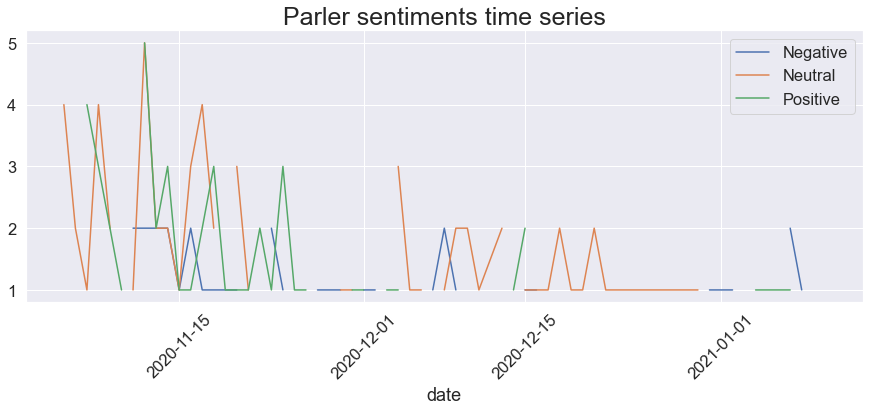

In [96]:
steal_sentiment_counts_per_day = steal_term_df.groupby(['date', 'sentiment']).size().to_frame('size').unstack('sentiment')
steal_sentiment_counts_per_day.reset_index().sort_values(by='date', ascending=True).plot(figsize=(15,5), x='date', rot=45, legend=False)
plt.title('Parler sentiments time series', size=25)
plt.legend(['Negative', 'Neutral', 'Positive'])

In [97]:
sentiment_counts_per_date = df.groupby(['date', 'sentiment']).size().to_frame('size').reset_index()
max_negative_date_index = sentiment_counts_per_date[sentiment_counts_per_date.sentiment == 'negative']['size'].nlargest(3).index
top_negative_sentiment_dates = sentiment_counts_per_date.loc[max_negative_date_index]
top_negative_sentiment_dates

date sentiment  size
1109  2021-01-08  negative   243
947   2020-11-15  negative   242
953   2020-11-17  negative   240

# First time Trump said

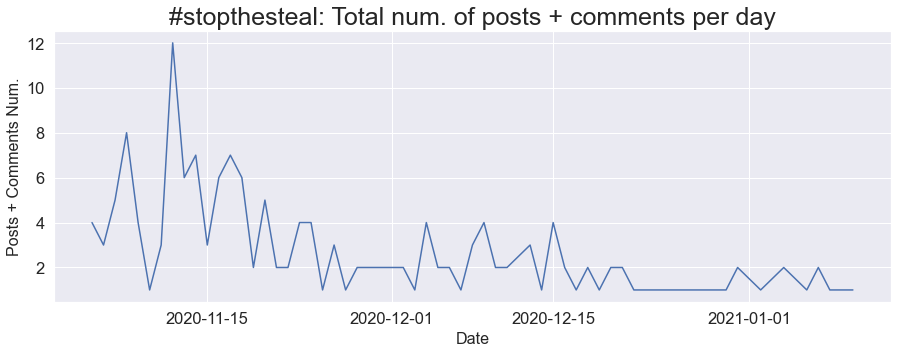

In [71]:
stopthesteal_df = df[df.hashtags.apply(lambda x: 'stopthesteal' in x)]

# Plot time series of number of comments per date.
posts_coms_per_day = stopthesteal_df.groupby('date').size()
posts_coms_per_day.reset_index().sort_values(by='date', ascending=True).plot(figsize=(15,5), x='date', legend=False, x_compat=True)
plt.xlabel("Date",size=16)
plt.ylabel("Posts + Comments Num.",size=16)
plt.title("#stopthesteal: Total num. of posts + comments per day", size=25)
plt.savefig("stopthesteal.png", dpi=50)

We can see that stop the steal has started being used after 7th september when Jack Posobiec tweets “#StopTheSteal 2020 is coming…”.